[View in Colaboratory](https://colab.research.google.com/github/lycohen/ds_desafio_I/blob/master/Desafio_2_3.ipynb)

In [118]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1u2lMckjqMlD-7qXfV8i8MJiQm_6GbLX9'
downloaded = drive.CreateFile({'id': file_id})
# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('properatti.csv')

!pip install stop-words

!pip install regex

!pip install unidecode

In [0]:

% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.preprocessing import scale


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


from sklearn.feature_extraction import DictVectorizer


from scipy.sparse import hstack


from stop_words import get_stop_words
import unidecode
import re

excluyoZonas=False
tomoSampleo=True
columnasToDummy = ['property_type']
columnasToFill = [ 'property_type','new_usd_per_m2','place_name','rooms','surface_total_in_m2','surface_covered_in_m2','floor']
columnasFilled = [ 'rooms_filled','surface_total_in_m2_filled','surface_covered_in_m2']
columnasMonetarias=['currency','price_aprox_usd','price','price_usd_per_m2','price_per_m2','price_aprox_local_currency']
columnasToDel = ['Unnamed: 0', 'operation',  'place_name',
       'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 
       'floor',  'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail']


In [0]:
df = pd.read_csv('./properatti.csv')  # Dataset de PROPERATI
### si descomento tengo un conjunto acotado
if (tomoSampleo):
    df =df[:5000]
#if(excluyoZonas):
#    df_zonas_count = df.groupby(by='place_with_parent_names').agg({'property_type':'count'})
#    ### obtengo las zonas que tengan pocos elementos. Si tengo mas features que elementos no sirve
#    ### para clasificar.
#    ### no se que hacer!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#    df_zonas_count=df_zonas_count[df_zonas_count['property_type'] <df_zonas_count['property_type'].std()*1.5 ].index


In [0]:
# Creamos una pivot table para la media de surface_covered_in_m2 agrupada por place_name y property_type.
flattened_pivot_surface = pd.DataFrame(df.pivot_table(values = 'surface_covered_in_m2', index = ['place_name','property_type'],
                                aggfunc = 'mean').to_records())

In [0]:
cleaned_df = df.merge(flattened_pivot_surface, how='left', on=['place_name','property_type'])


In [0]:
# Imputamos las medias agrupadas y eliminamos las variables redundantes
cleaned_df.surface_covered_in_m2_x.fillna(cleaned_df.surface_covered_in_m2_y, inplace=True)
del cleaned_df['surface_covered_in_m2_y']
cleaned_df['surface_covered_in_m2'] = cleaned_df['surface_covered_in_m2_x']
del cleaned_df['surface_covered_in_m2_x']

In [0]:
# Generamos las dummies para property_type
cleaned_df = pd.get_dummies(cleaned_df, columns=['property_type'])

In [834]:
dfBackup = cleaned_df
df = cleaned_df
#######imputo y borro lo que me queda afuera.----version 11:00am
df = df.dropna(subset=columnasMonetarias)
df = df.drop(columnasToDel,axis=1)

df.shape



(1422, 14)

In [835]:
df.columns

Index(['place_with_parent_names', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'rooms', 'surface_covered_in_m2',
       'property_type_PH', 'property_type_apartment', 'property_type_house',
       'property_type_store'],
      dtype='object')

In [0]:
def inversaPrecio(dfTmp):
  dfTmp['new_usd_per_m2'] = dfTmp['new_usd_per_m2'].apply(lambda x:np.exp(x))
  return dfTmp



In [0]:
### normalizo precio.
### todavia no se sirve pero la teoria parece indicar que si para evitar la dispersion 
## que observamos en desafio I

def normalizoPrice(seriePrecioNuevo):
    from sklearn.preprocessing import FunctionTransformer
    # Instancio el Optimus Prime con log1p
    transformer = FunctionTransformer(np.log1p)
    return transformer.transform(seriePrecioNuevo.reshape(-1,1))
  
def imputoPrecio(dfTmp):
    dummies_price = pd.get_dummies(dfTmp['currency'])
    dfTmp["ars"] = dfTmp["price"] * dummies_price["ARS"]
    dfTmp["USDaprox"] = dfTmp["ars"] / (dfTmp["price_aprox_usd"] * dummies_price["ARS"])

    USD = dfTmp["USDaprox"].median()
    
    y = dfTmp["price_per_m2"]/USD
    #######imputo y borro lo que me queda afuera.----version 11:00am
    dfTmp = dfTmp.dropna(subset=columnasMonetarias)
    #dfTmp["new_usd_per_m2"] = inversaPrecio(normalizoPrice(dfTmp["price_usd_per_m2"]))
    dfTmp["new_usd_per_m2"] = dfTmp["price_usd_per_m2"]*dfTmp['surface_covered_in_m2']
    return dfTmp
  



In [838]:
columnasMonetarias

['currency',
 'price_aprox_usd',
 'price',
 'price_usd_per_m2',
 'price_per_m2',
 'price_aprox_local_currency']

In [839]:
dfMonetario=df[['currency',
 'price_aprox_usd',
 'price',
 'price_usd_per_m2',
 'price_per_m2',
 'price_aprox_local_currency','surface_covered_in_m2']]
#dfMonetario =dfMonetario.dropna()
#display(dfMonetario.isna().sum())

Y =imputoPrecio(dfMonetario)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [840]:
Y = Y.drop(columns =columnasMonetarias,axis=1)
df=df.drop(columns =columnasMonetarias,axis=1)
Y.shape

(1422, 4)

In [841]:
df.columns


Index(['place_with_parent_names', 'surface_total_in_m2', 'rooms',
       'surface_covered_in_m2', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store'],
      dtype='object')

In [842]:
df.describe()

,surface_total_in_m2,rooms,surface_covered_in_m2,property_type_PH,property_type_apartment,property_type_house,property_type_store
count,1422.000000,854.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,265.473980,2.805621,136.068917,0.053446,0.608298,0.318565,0.019691
std,1276.302511,1.339163,504.647746,0.225000,0.488302,0.466084,0.138984
min,20.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000
50%,96.500000,3.000000,80.000000,0.000000,1.000000,0.000000,0.000000
75%,233.750000,4.000000,160.000000,0.000000,1.000000,1.000000,0.000000
max,45000.000000,10.000000,18615.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
### dada una lista de dummy definida arriba la convierto a dummy .
### el flag de sparse no funciona.
def setMatricesDummy(columnas,dfTmp,esSparse):
    frames = []
    for i in columnas:
        frames.append( pd.get_dummies( dfTmp[i ],sparse=esSparse))
    pdCompleto=pd.concat(frames,axis=1,join='outer')
    
    return pdCompleto



In [0]:
### defino la lista de palabras que no contamos con el count vectorizer
def getStopWords():
    stop_words=get_stop_words('spanish')
    stop_words_xl = [',',':','!','/','$','+','?','|','!!','!!!','$','+','-','//',' ','ambientes','ph','departamento','casa','.','argentina','u$d','u$s','venta','vende','vendo','amb','ambiente','ambientes','u$s','u$d']
    return stop_words + stop_words_xl + df['place_name'].apply(lambda x:(str(x).lower())).tolist() +df['country_name'].apply(lambda x:(str(x).lower())).tolist() +df['state_name'].apply(lambda x:(str(x).lower())).tolist() 
### diccionario de palabras que descubrio count vectorizer. finalmente no uso el diccionario 
### sirve para ver que hay

### borro numeros en el analisis de palabras. no quiero valores numericos que le pongo al modelo 
### por otro lado.
def dropNumero(x):
    p = re.compile(r'\d')
    if (bool(p.search(x))):
        return ''
    else:
        return x
### saco acentos
def sacoAcentos(s):
    return unidecode.unidecode(s)
### convierto oraciones a listas de palabras
### de vuelta saco los numeros y los reemplazo por una palabra clave 
def getTexto(col):
    return col.replace('\d+', '|NUM|', regex=True).apply(lambda x:sacoAcentos(x)).apply(lambda x:(x.lower().replace('.','').split()))
    
def getPlaces(dfTmp):
    return dfTmp['place_with_parent_names'].apply(lambda x:x.split('|'))

def getPropertyTpes(dfTmp):
    return dfTmp['property_type']

def extraigoColsConValorNumericoDeFeatures(dfTmp):
    ## si hay un valor numerico en el titulo que muestra al model algun feature numerico de otra columna es un problema.
    ##mejor sacar
    col2drop =[]
    for i in dfTmp.columns:
        if ('num' in i):
            col2drop.append(i)
    dfTmp.drop(col2drop,axis=1,inplace=True)
    return dfTmp    

In [0]:
df['rooms'].fillna(0,inplace=True)



In [0]:
fullDF  = pd.concat([Y,df],axis=1)



In [0]:
#fullDF.sample(10)

In [0]:
def getFeaturesFromPlacesSparse(dfTmp):
    #stop_words=getStopWords()
    cvec=TfidfVectorizer(ngram_range=(1,3),strip_accents=None, token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    #tfidf= TfidfTransformer(use_idf=True,smooth_idf=True)
    pipeline=Pipeline([('vect',cvec),
                      #('tfidf',tfidf),
                      #('clf',MultinomialNB(alpha=1))
                      ])
    
    
    sdf = pd.SparseDataFrame(pipeline.fit_transform(getPlaces(dfTmp)),
                         columns=cvec.get_feature_names(), 
                         default_fill_value=0)
    return sdf
    
featuresFromPlacesSparse=   getFeaturesFromPlacesSparse(fullDF)



In [0]:
#fullDF  = pd.concat([fullDF,featuresFromPlacesSparse],axis=1)



In [849]:
fullDF.columns

Index(['surface_covered_in_m2', 'ars', 'USDaprox', 'new_usd_per_m2',
       'place_with_parent_names', 'surface_total_in_m2', 'rooms',
       'surface_covered_in_m2', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store'],
      dtype='object')

In [0]:
fullDF.drop(['place_with_parent_names','ars', 'USDaprox', ],axis=1,inplace=True)

In [0]:
fullDF.dropna(inplace=True)

In [852]:
fullDF.sample(10)

,surface_covered_in_m2,new_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2,property_type_PH,property_type_apartment,property_type_house,property_type_store
4854,70.0,139000.000000,70.0,0.0,70.0,0,1,0,0
1305,54.0,133043.478261,69.0,2.0,54.0,0,1,0,0
1187,71.0,239003.750000,84.0,3.0,71.0,0,1,0,0
581,61.0,178000.000000,61.0,2.0,61.0,0,1,0,0
1210,37.0,110000.000000,37.0,2.0,37.0,0,1,0,0
4928,67.0,200094.594595,74.0,3.0,67.0,0,1,0,0
57,30.0,250000.000000,30.0,0.0,30.0,0,0,0,1
4588,45.0,78000.000000,45.0,2.0,45.0,0,1,0,0
272,62.0,134333.333333,66.0,0.0,62.0,0,1,0,0
4855,175.0,87500.000000,250.0,0.0,175.0,0,0,1,0


In [853]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
minmaxscaler_model = MinMaxScaler()
fullDF['rooms_scaled'] = minmaxscaler_model.fit_transform(fullDF['rooms'].reshape(-1,1))
fullDF['surface_total_in_m2_scaled'] = minmaxscaler_model.fit_transform(fullDF['surface_total_in_m2'].reshape(-1,1))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


In [0]:
#fullDF['surface_covered_in_m2_scaled'] = minmaxscaler_model.fit_transform(fullDF['surface_covered_in_m2'].reshape(-1,1))




In [0]:
fullDF.drop(['surface_total_in_m2', 'rooms','surface_covered_in_m2' ],axis=1,inplace=True)

In [0]:
def getFeaturesFromPropertyTypes(dfTmp):
    #stop_words=getStopWords()
    cvec=TfidfVectorizer(strip_accents=None, analyzer='word' ,lowercase=False)
    #tfidf= TfidfTransformer(use_idf=True,smooth_idf=True)
    pipeline=Pipeline([('vect',cvec),
                      #('tfidf',tfidf),
                      #('clf',MultinomialNB(alpha=1))
                      ])
    
    
    sdf = pd.SparseDataFrame(pipeline.fit_transform(getPropertyTpes(dfTmp)),
                         columns=cvec.get_feature_names(), 
                         default_fill_value=0)
    return sdf
    
#featuresFromPropertyTypes=   getFeaturesFromPropertyTypes(fullDF)

#fullDF = pd.concat([fullDF,featuresFromPropertyTypes],axis=1)
#fullDF.drop(['property_type'],axis=1,inplace=True)

In [0]:
fullDF.dropna(inplace=True)

In [0]:

### tengo una sparse con las ubicaciones    
#def getTransfPipeline(dfTmp):
#    #dfCopy = dfTmp.drop(['surface_total_in_m2', 'rooms'],axis=1)
#    cvec=CountVectorizer(ngram_range=(1,3),strip_accents=None, token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
#    pipeline=Pipeline([      ('vect',cvec),
#                      ('tfidf',TfidfTransformer(use_idf=True,smooth_idf=True)),
#                       ( 'stdSc',StandardScaler(with_mean=False)),
#                       ( 'minmax',MaxAbsScaler())
#                      ])
#    pipeline.fit_transform(dfTmp)
#    return pipeline
#XPipeline = getTransfPipeline(fullDF) 
#dfTransformado= pd.DataFrame(XPipeline, index=fullDF.index, columns=fullDF.columns)  



In [855]:
fullDF.columns

Index(['surface_covered_in_m2', 'new_usd_per_m2', 'surface_total_in_m2',
       'rooms', 'surface_covered_in_m2', 'property_type_PH',
       'property_type_apartment', 'property_type_house', 'property_type_store',
       'rooms_scaled', 'surface_total_in_m2_scaled'],
      dtype='object')

In [0]:
#######OBTENGO 100 de manera random
indices = np.random.choice(fullDF['new_usd_per_m2'].index,100,replace=True)
#indices=np.random.choice(fullDF['new_usd_per_m2'].index.shape(0),100,replace=False)





In [857]:
fullDF.sample(10)

,surface_covered_in_m2,new_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2,property_type_PH,property_type_apartment,property_type_house,property_type_store,rooms_scaled,surface_total_in_m2_scaled
591,75.0,225000.000000,75.0,3.0,75.0,0,1,0,0,0.3,0.001223
411,60.0,120000.000000,60.0,2.0,60.0,0,1,0,0,0.2,0.000889
4537,54.0,130050.000000,60.0,2.0,54.0,0,1,0,0,0.2,0.000889
4281,65.0,56083.670000,65.0,5.0,65.0,0,1,0,0,0.5,0.001000
400,50.0,324074.074074,54.0,2.0,50.0,0,1,0,0,0.2,0.000756
51,324.0,353571.428571,504.0,0.0,324.0,0,0,1,0,0.0,0.010760
1200,52.0,182000.000000,60.0,2.0,52.0,0,1,0,0,0.2,0.000889
4289,70.0,133636.363636,110.0,3.0,70.0,0,1,0,0,0.3,0.002001
4673,235.0,320000.000000,235.0,0.0,235.0,0,0,1,0,0.0,0.004780
1286,49.0,141842.105263,57.0,2.0,49.0,0,1,0,0,0.2,0.000823


In [0]:
choicesCompraVenta = fullDF.loc[indices]


In [0]:
choiceAnalisis = fullDF[~fullDF.index.isin(indices)]

In [0]:
fullDF= choiceAnalisis
y = fullDF.loc[ fullDF['new_usd_per_m2'].index]['new_usd_per_m2']
yCompraVenta = choicesCompraVenta.loc[ choicesCompraVenta['new_usd_per_m2'].index]['new_usd_per_m2']

In [0]:
fullDF.drop(['new_usd_per_m2'],axis=1,inplace=True)




In [0]:
choicesCompraVenta.drop(['new_usd_per_m2'],axis=1,inplace=True)
#

In [0]:
#choiceAnalisis.drop(['new_usd_per_m2'],axis=1,inplace=True)




In [863]:
choicesCompraVenta

,surface_covered_in_m2,surface_total_in_m2,rooms,surface_covered_in_m2,property_type_PH,property_type_apartment,property_type_house,property_type_store,rooms_scaled,surface_total_in_m2_scaled
4607,24.0,24.0,1.0,24.0,0,1,0,0,0.1,0.000089
1159,100.0,110.0,3.0,100.0,0,1,0,0,0.3,0.002001
715,51.0,51.0,0.0,51.0,0,1,0,0,0.0,0.000689
1246,130.0,190.0,4.0,130.0,0,1,0,0,0.4,0.003779
4570,200.0,200.0,0.0,200.0,0,0,1,0,0.0,0.004002
4904,66.0,71.0,3.0,66.0,0,1,0,0,0.3,0.001134
360,27.0,27.0,0.0,27.0,0,1,0,0,0.0,0.000156
4540,90.0,90.0,1.0,90.0,1,0,0,0,0.1,0.001556
1213,52.0,58.0,2.0,52.0,0,1,0,0,0.2,0.000845
262,37.0,37.0,3.0,37.0,0,1,0,0,0.3,0.000378


In [864]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt





# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(fullDF, y, test_size=0.2)

#getTransfPipeline(X_train) 
display (X_train.shape, y_train.shape)
display (X_test.shape, y_test.shape)

#X_transf_test =XPipeline.transform(X_test).data
#X_transf_train=XPipeline.transform(X_train).data

#display(X_transf_train.shape,X_transf_test.shape)


(1057, 10)

(1057,)

(265, 10)

(265,)

## obtengo mis x -> matriz
## y -> precio

In [0]:
#X_transf_test.shape

In [0]:

# fit a model
lm = linear_model.LinearRegression(fit_intercept=True,normalize=True)
#lm = linear_model.Lasso(alpha=15)
#lm = linear_model.Ridge(alpha=15)
#lm=linear_model.ElasticNet(alpha=0.01)



model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


Text(0,0.5,'Predictions')

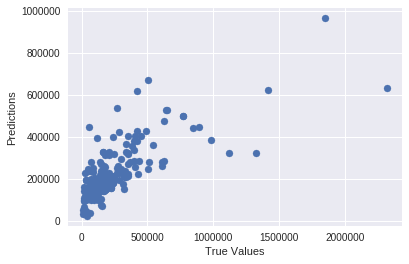

In [867]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions') 




## 2da PARTE

In [0]:
#dfSample = dfCompleto.sample(10)

In [0]:
# create training and testing vars


In [0]:

#from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
#model_bic = LassoLarsIC(criterion='bic')
#model_bic.fit(matriz.toarray(), precios)
#alpha_bic_ = model_bic.alpha_

#model_aic = LassoLarsIC(criterion='aic')
#model_aic.fit(matriz.toarray(),precios)
#alpha_aic_ = model_aic.alpha_

#display(alpha_bic_,alpha_aic_)

# Tengo x e y
# Vamos jugando con los modelos

In [870]:
predictions[0:5]

array([154112., 200960., 227584., 357120., 234496.])

In [0]:
## The line / model


In [871]:
print ('Score:', model.score(X_test, y_test))

Score: 0.48789209812916945


In [872]:
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=6) # Define the split - into 2 folds 
kf.get_n_splits(df) # returns the number of splitting iterations in the cross-validator

6

In [0]:
#for train_index, test_index in kf.split(df):
#    print('Train', train_index, 'Test', test_index)
#    X_train, X_test = df[train_index], df[test_index]
#    y_train, y_test = y[train_index], y[test_index]


In [0]:
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [874]:

# Perform 6-fold cross validation
scores = cross_val_score(model, fullDF, y, cv=6)
print ('Cross-validated scores:', scores)

Cross-validated scores: [0.45184532 0.5265953  0.50341211 0.46765626 0.41031541 0.39468047]


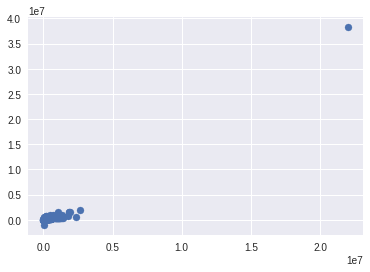

In [875]:
# Make cross validated predictions
predictions = cross_val_predict(model, fullDF, y, cv=6)
plt.scatter(y, predictions)

In [876]:
accuracy = metrics.r2_score(y, predictions)
print (accuracy)

0.45830207224933595


# 3. Comparación Modelos

In [0]:
# Importamos librerías

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold # import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [0]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

al_ridge = np.linspace(0.001, 20, 10)
al_lasso = np.linspace(0.1, 10, 10)
kf = KFold(n_splits=6, shuffle=True, random_state=12)

# Instanciamos los modelos

lm = LinearRegression(fit_intercept=True,normalize=True)
lmRidgeCV = RidgeCV(alphas=al_ridge, cv=kf, normalize=False)
lmLassoCV = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

## 3.1 Regresión lineal

In [879]:
# Entrenamos el modelo LM

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print ('Score:', model.score(X_test, y_test))

Score: 0.48789209812916945


In [880]:
# Hacemos cross validation

scores = cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2') 
scores, scores.mean()

(array([0.48142369, 0.47884595, 0.65898519, 0.57639288, 0.48987804,
        0.67732034]), 0.5604743477100523)

## 3.2 Modelo Ridge

In [881]:
# Entrenamos el modelo Ridge

ridgemodel = lmRidgeCV.fit(X_train, y_train)
ridgemodel.score

<bound method RegressorMixin.score of RidgeCV(alphas=array([1.00000e-03, 2.22311e+00, 4.44522e+00, 6.66733e+00, 8.88944e+00,
       1.11116e+01, 1.33337e+01, 1.55558e+01, 1.77779e+01, 2.00000e+01]),
    cv=KFold(n_splits=6, random_state=12, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)>

In [882]:
#Hacemos cross validation

scores = cross_val_score(ridgemodel, X_train, y_train, cv=kf, scoring='r2')
dict(alpha=ridgemodel.alpha_, scores=scores, mean_score=scores.mean())

{'alpha': 20.0,
 'mean_score': 0.5584205065841279,
 'scores': array([0.48788105, 0.4770398 , 0.65895231, 0.58155229, 0.4884888 ,
        0.65660878])}

In [883]:
print ("r^2:", ridgemodel.score(X_test, y_test))
print ("alpha:", ridgemodel.alpha_)

r^2: 0.48540596592575225
alpha: 20.0


## 3.3 Modelo Lasso

In [0]:
# Entrenamos el modelo Lasso

lassomodel = lmLassoCV.fit(X_train, y_train)

In [885]:
#Hacemos cross validation

scores = cross_val_score(lassomodel, X_train, y_train, cv=kf, scoring='r2')
dict(alpha=lassomodel.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 10.0,
 'mean_score': 0.5589494663216967,
 'scores': array([0.48519684, 0.47866592, 0.65951736, 0.58342355, 0.49028529,
        0.65660783]),
 'zero_coefs': 0}

In [886]:
print ("r^2:", lassomodel.score(X_test, y_test))
print ("alpha:", lassomodel.alpha_)

r^2: 0.48770064604374574
alpha: 10.0


## 3.4 ElasticNet

In [887]:
elasticnet_model = linear_model.ElasticNet()

# Ajustamos nuevamente, esta vez con regularizacion

elasticnet_model = elasticnet_model.fit(X_train, y_train)
predictions = elasticnet_model.predict(X_test)

print ("r^2:", elasticnet_model.score(X_test, y_test))

r^2: 0.474357984480934


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## 3.5 Graficación Alphas

In [0]:
# Usando Gridsearch para encontrar los parámetros

In [0]:
## Estimacion

## Precios - clasificador

In [889]:
len(yPredict)

100

In [891]:
len(yCompraVenta)

100

In [894]:
len(choicesCompraVenta)

100

In [0]:
predictedY = lm.predict(choicesCompraVenta)

In [0]:
medianaMuestra = yCompraVenta.to_frame()['new_usd_per_m2'].median()

In [0]:

presupuesto = yCompraVenta.to_frame()['new_usd_per_m2'].sum()

In [0]:
desvio = yCompraVenta.to_frame()['new_usd_per_m2'].std()



In [0]:
choicesCompraVenta['precio_prd'] = predictedY

In [0]:
choicesCompraVenta['precio_real']=yCompraVenta.to_frame()['new_usd_per_m2']

In [903]:
choicesCompraVenta.columns#(choicesCompraVenta['precio_pred']/medianaMuestra

Index(['surface_covered_in_m2', 'surface_total_in_m2', 'rooms',
       'surface_covered_in_m2', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store', 'rooms_scaled',
       'surface_total_in_m2_scaled', 'precio_prd', 'precio_real'],
      dtype='object')

In [0]:
choicesCompraVenta['precio_vs_pred'] = (choicesCompraVenta['precio_real']-choicesCompraVenta['precio_prd'])/choicesCompraVenta['precio_prd']

In [0]:
dfSorted = choicesCompraVenta.sort_values(by=['precio_vs_pred'])


In [920]:
dfSorted

,surface_covered_in_m2,surface_total_in_m2,rooms,surface_covered_in_m2,property_type_PH,property_type_apartment,property_type_house,property_type_store,rooms_scaled,surface_total_in_m2_scaled,precio_prd,precio_real,precio_vs_pred
1636,100.0,773.0,4.0,100.0,0,0,1,0,0.4,0.016741,159232.0,5078.728331,-0.968105
907,54.0,400.0,2.0,54.0,0,0,1,0,0.2,0.008448,95744.0,4173.714000,-0.956408
1012,250.0,2250.0,0.0,250.0,0,0,1,0,0.0,0.049578,290560.0,13222.222222,-0.954494
966,180.0,900.0,4.0,180.0,0,0,1,0,0.4,0.019564,253696.0,53000.000000,-0.791089
1013,81.0,240.0,0.0,81.0,0,0,1,0,0.0,0.004891,116992.0,32062.500000,-0.725943
4790,20.0,750.0,0.0,20.0,0,0,1,0,0.0,0.016229,36096.0,11600.000000,-0.678635
4369,25.0,816.0,0.0,25.0,0,0,1,0,0.0,0.017697,41216.0,13480.392157,-0.672933
651,100.0,100.0,0.0,100.0,0,0,1,0,0.0,0.001779,141568.0,47671.120000,-0.663263
1024,56.0,56.0,0.0,56.0,0,0,0,1,0.0,0.000800,178176.0,65000.000000,-0.635192
1055,180.0,450.0,4.0,180.0,0,0,1,0,0.4,0.009560,260352.0,96000.000000,-0.631268


In [0]:
####mi presupuesto es arbitrario. es mi capital
presupuesto=2000000

In [0]:
###compro las subvaluadas hasta que se me acaba presupuesto . luego vendo las sobrevaluadas.
avender=[]
acomprar=[]
for i,j in dfSorted['precio_vs_pred'].iteritems():
  if (presupuesto>0):
    precioReal=dfSorted.loc[i]['precio_real']
    precioPred=dfSorted.loc[i]['precio_prd']
    acomprar.append(i)
    presupuesto  = presupuesto -precioPred
    #print(i,j,precioReal,precioPred)
  

PROPIEDADES A COMPRAR SEGUN MI PRESUPUESTO

In [964]:
dfRenew  = pd.read_csv('./properatti.csv')  # Dataset de PROPERATI
dfRenew.loc[acomprar]

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
1636,1636,sell,house,Chascomús,|Argentina|Buenos Aires Interior|Chascomús|Cha...,Argentina,Buenos Aires Interior,NaN,"-35.5799353,-57.9735323",-35.579935,...,100.0,50.787283,7000.000000,NaN,4.0,NaN,http://www.properati.com.ar/15j1i_venta_casa_c...,CASA EN VENTA EN CHASCOMUSCONSTRUIDA SOBRE UN ...,CASA EN VENTA,https://thumbs4.properati.com/4/2sx6dnqVWQ32Oi...
907,907,sell,house,Tanti,|Argentina|Córdoba|Tanti|,Argentina,Córdoba,3834652.0,"-38.416097,-63.616672",-38.416097,...,54.0,77.291000,9814.814815,NaN,2.0,NaN,http://www.properati.com.ar/15ghg_venta_casa_t...,Casa de 10 años de antigüedad conformada por 1...,Casa venta,https://thumbs4.properati.com/9/42jG_goABaTOep...
1012,1012,sell,house,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863.0,"-38.2337405259,-57.7629524058",-38.233741,...,250.0,52.888889,476.000000,NaN,NaN,NaN,http://www.properati.com.ar/15gwr_venta_casa_m...,CODIGO: 2923-ABC164 ubicado en: Calle 81 esq 1...,VENDO CASA DE CAMPO SAN EDUARDO DEL MAR,https://thumbs4.properati.com/6/cT2sKEa4a8KmA5...
966,966,sell,house,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863.0,"-38.0054771,-57.5426106",-38.005477,...,180.0,294.444444,1472.222222,NaN,4.0,NaN,http://www.properati.com.ar/15gpa_venta_casa_m...,Superficie cubierta 180 m² sobre lote de 900 m...,Chalet 4 ambientes sobre dos lotes con pileta....,https://thumbs4.properati.com/7/Sx5YPsLZg3x66c...
1013,1013,sell,house,Burzaco,|Argentina|Bs.As. G.B.A. Zona Sur|Almirante Br...,Argentina,Bs.As. G.B.A. Zona Sur,3435894.0,"-34.8269961,-58.4016469",-34.826996,...,81.0,395.833333,1172.839506,NaN,NaN,NaN,http://www.properati.com.ar/15gwu_venta_casa_b...,CODIGO: 64 ubicado en: BRADLEY 1491 - Publica...,CASA CON RENTA,https://thumbs4.properati.com/5/jZl5NcfYQVySMI...
4790,4790,sell,house,Benavidez,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Bena...,Argentina,Bs.As. G.B.A. Zona Norte,3436048.0,NaN,NaN,...,20.0,580.000000,21750.000000,NaN,NaN,NaN,http://www.properati.com.ar/15nvl_venta_casa_b...,Hermosa casa de estilo en el Barrio San Isidro...,"Casa 750m² con 2 Plantas, Tigre, Benavidez, po...",https://thumbs4.properati.com/5/a50BxhkDpDPiXE...
4369,4369,sell,house,Benavidez,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Bena...,Argentina,Bs.As. G.B.A. Zona Norte,3436048.0,NaN,NaN,...,25.0,539.215686,17600.000000,NaN,NaN,NaN,http://www.properati.com.ar/15mmi_venta_casa_b...,En su interior nos recibe un grato hall de rec...,"Casa 816m² con 2 Plantas, Tigre, Benavidez, po...",https://thumbs4.properati.com/0/8yWrUgR6yF36im...
651,651,sell,house,Longchamps,|Argentina|Bs.As. G.B.A. Zona Sur|Almirante Br...,Argentina,Bs.As. G.B.A. Zona Sur,3431259.0,"-34.8562309,-58.374911",-34.856231,...,100.0,476.711200,8500.000000,NaN,NaN,NaN,http://www.properati.com.ar/15fhy_venta_casa_l...,Casa sobre la calle Canalejas con jardín al fr...,Casa 2 dormitorios y Dpto a terminar en Longch...,https://thumbs4.properati.com/3/4E4up8f9WakRmv...
1024,1024,sell,store,Barrio Norte,|Argentina|Capital Federal|Barrio Norte|,Argentina,Capital Federal,3436109.0,NaN,NaN,...,56.0,1160.714286,1160.714286,NaN,NaN,4000.0,http://www.properati.com.ar/15gyg_venta_local_...,CODIGO: 3016-WP0209 ubicado en: Talcahuano 107...,Local doble en Galería 5ta avenida,https://thumbs4.properati.com/6/ArdMzra6W1aCJP...
1055,1055,sell,house,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863.0,"-38.0139431,-57.5671155",-38.013943,...,180.0,533.333333,1333.333333,NaN,4.0,NaN,http://www.properati.com.ar/15h21_venta_casa_m...,"Posibilidad por zona,de construccion edificio ...",Chalet en Venta. Ambientes. Dormitorios. 450 m...

PROPIEDADES A VENDER SEGUN MI PRESUPUESTO

In [965]:
dfRenew[~dfRenew.index.isin(acomprar)]

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
5,5,sell,house,Gualeguaychú,|Argentina|Entre Ríos|Gualeguaychú|,Argentina,Entre Ríos,3433657.0,"-33.0140714,-58.519828",-33.014071,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bop_venta_depart...,"Casa en el perímetro del barrio 338, ubicada e...","Casa Barrio 338. Sobre calle 3 de caballería, ...",https://thumbs4.properati.com/6/q-w68gvaUEQVXI...
6,6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,...,78.0,1226.415094,1666.666667,NaN,NaN,NaN,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",https://thumbs4.properati.com/5/6GOXsHCyDu1aGx...
7,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,40.0,3066.666667,3450.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...
8,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,60.0,3000.000000,3250.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...
9,9,sell,house,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.942031,-60.7259192",-32.942031,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15box_venta_casa_r...,MEDNOZA AL 7600A UNA CUADRA DE CALLE MENDOZAWH...,WHITE 7637 - 2 DORMITORIOS CON PATIO,https://thumbs4.properati.com/8/RCf1YEWdF4rv98...
